In [ ]:
from google.colab import drive
import os
drive.mount("./content/")
os.chdir("./content/MyDrive/cs577/project_files/")

Mounted at ./content/


In [ ]:
import scipy as sp
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import random
import gensim

In [ ]:
# these are our dataset used to train the embeddings and measure biases on.
df_real = pd.read_csv("./real_news.csv")
df_fake = pd.read_csv("./fake_news.csv")

In [ ]:
# trained embeddings on fake and real news using the official Glove repository https://github.com/stanfordnlp/GloVe
real_vec_df = pd.read_csv("./real_news/vectors.txt", delimiter=" ", header=None)
fake_vec_df = pd.read_csv("./fake_news/vectors.txt", delimiter=" ", header=None)

In [ ]:
#from dataframe to dict -> {word: embedding}

real_vec_dict = {}
for i in range(len(real_vec_df)):
  vec = [c for c in real_vec_df.iloc[i, 1:]]
  real_vec_dict[real_vec_df.iloc[i, 0]] = vec

fake_vec_dict = {}
for i in range(len(fake_vec_df)):
  vec = [c for c in fake_vec_df.iloc[i, 1:]]
  fake_vec_dict[fake_vec_df.iloc[i, 0]] = vec

In [ ]:
# finetuned Word2Vec embeddings on fake and real news 

w2v_model_real = gensim.models.word2vec.Word2Vec.load('real_embeddings')
w2v_model_fake = gensim.models.word2vec.Word2Vec.load('fake_embeddings')


In [ ]:
###
# The way the words are chosen are very adhoc. For the attributes, I simply
# choose words that exist in both fake and real news and have a close relationship
# with the attribute they represent (not necessary the target), although these 
# attribute words exist in the same article with the target words. The attributes
# are chosen represent the biases against and for the targets. 
# Target 1 and target 2 are the emebddings of the same list of words, (asia for example)
# but in real news and fake news contexts. Atributes 1 and attributes 2 each have 
# real and fake news emebddings to measure the bias of real and fake targets.
###

# Asian-Health bias
asia = ["asia", "asian", "wuhan", "china", "chinese"]
danger =  ["danger","harm","risk", "infectious"]
healthy = ["healthy", "safe", "asymptomatic"]

# Vaccine-AntiVaccine
vac = ["vaccine"]
antivac = ["harm", "danger","dangerous","risk", "distress"]
provac = ["safe", "effective", "useful", "healthy", "great"]


In [ ]:
# ------------------------------ WEAT TEST -----------------------------------

from scipy.stats import norm

def distance_func(target, attribute1, attribute2):
  # implementing s(x,A,B)
  # return a vector of s(x,A,B) for each x := target

  sim1 = np.mean(cosine_similarity(target, attribute1), axis=1)
  sim2 = np.mean(cosine_similarity(target, attribute2), axis=1)

  return sim1 - sim2

def test_statistic(target1_sim, target2_sim):
  # getting s(X,Y,A,B) from the vectors s(x,A,B) and s(y,A,B)
  # return a scalar 

  if len(target1_sim) != len(target2_sim):
    print("Wrong length")

  return sum(target1_sim) - sum(target2_sim)

def get_targets_and_attribute_vectors(targets, attribute1, attribute2, real_vec, fake_vec):

    real_target = [real_vec[w] for w in targets]
    fake_target = [fake_vec[w] for w in targets]

    real_att1 = [real_vec[w] for w in attribute1]
    real_att2 = [real_vec[w] for w in attribute2]

    fake_att1 = [real_vec[w] for w in attribute1]
    fake_att2 = [real_vec[w] for w in attribute2]
    
    return real_target, fake_target, real_att1, real_att2, fake_att1, fake_att2


def null_dist(targets, attribute1, attribute2, real_vec, fake_vec, dist_size=4, loop=10):
  # null distbution for s(X,Y,A_1,B_1,A_2,B_2) with random variables X,Y

  dist = []
  for i in range(loop):
    random.shuffle(targets)
    tars = targets[:dist_size] #sampling random words as targets

    real_target, fake_target, real_att1, real_att2, fake_att1, fake_att2 = get_targets_and_attribute_vectors(tars, attribute1, attribute2, real_vec, fake_vec)

    dist1 = distance_func(real_target, real_att1, real_att2)
    dist2 = distance_func(fake_target, fake_att1, fake_att2)

    dist.append(test_statistic(dist1, dist2))
  
  mu = np.mean(dist)
  std = np.std(dist)

  return mu, std

def p(targets, all_targets, attribute1, attribute2, real_vec, fake_vec):
    #p test for the null dist

    real_target, fake_target, real_att1, real_att2, fake_att1, fake_att2 = get_targets_and_attribute_vectors(targets, attribute1, attribute2, real_vec, fake_vec)

    dist1 = distance_func(real_target, real_att1, real_att2)
    dist2 = distance_func(fake_target, fake_att1, fake_att2)

    test = test_statistic(dist1, dist2)

    mu, std = null_dist(all_targets, attribute1, attribute2, real_vec, fake_vec)

    p = norm.cdf(test, mu, std)

    return 1-p

def effect_size(targets, attribute1, attribute2, real_vec, fake_vec):
  # effect size of the distance

  real_target, fake_target, real_att1, real_att2, fake_att1, fake_att2 = get_targets_and_attribute_vectors(targets, attribute1, attribute2, real_vec, fake_vec)

  real_target_sim = distance_func(real_target, real_att1, real_att2)
  fake_target_sim = distance_func(fake_target, fake_att1, fake_att2)

  mu = np.mean(real_target_sim - fake_target_sim)

  sim  = np.concatenate((real_target_sim, fake_target_sim))

  std = np.std(sim)

  return mu/std

In [ ]:
# all targets are used to get the null distribution which is chosen at random
targets = vac
attribute1 = antivac
attribute2 = provac
all_targets = ["social", "federal", "candidate", "hospital", "hygiene"]

print("Statistics on Glove embeddings:")
print("p:",p(targets, all_targets, attribute1, attribute2, real_vec_dict, fake_vec_dict))
print("effect size:", effect_size(targets, attribute1, attribute2, real_vec_dict, fake_vec_dict))
print("\nStatistics on W2V embeddings:")
print("p:",p(targets, all_targets, attribute1, attribute2, w2v_model_real.wv, w2v_model_fake.wv))
print("effective:",effect_size(targets, attribute1, attribute2, w2v_model_real.wv, w2v_model_fake.wv))

Statistics on Glove embeddings:
p: 0.00038113675628070887
effect size: -2.0

Statistics on W2V embeddings:
p: 0.4334989160084184
effective: -2.0000002


In [ ]:
targets = asia
attribute1 = danger
attribute2 = healthy
all_targets = ["social", "federal", "candidate", "hospital", "hygiene"]

print("Statistics on Glove embeddings:")
print("p:",p(targets, all_targets, attribute1, attribute2, real_vec_dict, fake_vec_dict))
print("effect size:", effect_size(targets, attribute1, attribute2, real_vec_dict, fake_vec_dict))
print("\nStatistics on W2V embeddings:")
print("p:",p(targets, all_targets, attribute1, attribute2, w2v_model_real.wv, w2v_model_fake.wv))
print("effective:",effect_size(targets, attribute1, attribute2, w2v_model_real.wv, w2v_model_fake.wv))

Statistics on Glove embeddings:
p: 2.1319302238032023e-06
effect size: 0.09888214366047317

Statistics on W2V embeddings:
p: 0.024245122177779188
effective: 0.13547467


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# Asian bias

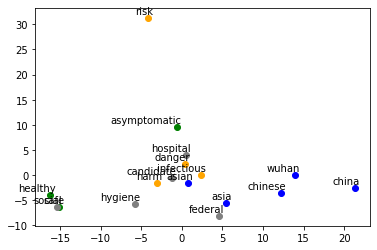

In [ ]:
# W2V real news
words = asia + healthy + danger + all_targets
n = [len(asia), len(asia)+len(healthy), len(asia)+len(healthy)+len(danger), len(asia)+len(healthy)+len(danger)+len(all_targets)]
word_vectors = np.array([w2v_model_real.wv[w] for w in words])
three_dim  = PCA(random_state=0).fit_transform(word_vectors)[:,:3]

plt.scatter(three_dim[:n[0],0], three_dim[:n[0],1], color="blue")
plt.scatter(three_dim[n[0]:n[1],0], three_dim[n[0]:n[1],1], color="green")
plt.scatter(three_dim[n[1]:n[2],0], three_dim[n[1]:n[2],1], color="orange")
plt.scatter(three_dim[n[2]:n[3],0], three_dim[n[2]:n[3],1], color="grey")
for i in range(len(words)):
  plt.annotate(words[i],
                xy=(three_dim[i,0], three_dim[i,1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom'
                )
plt.show()


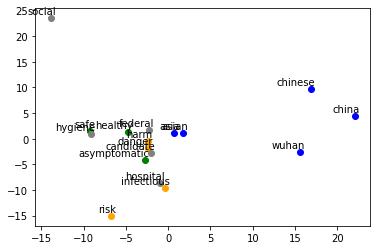

In [ ]:
# W2V fake news

words = asia + healthy + danger + all_targets
n = [len(asia), len(asia)+len(healthy), len(asia)+len(healthy)+len(danger), len(asia)+len(healthy)+len(danger)+len(all_targets)]
word_vectors = np.array([w2v_model_fake.wv[w] for w in words])
three_dim  = PCA(random_state=0).fit_transform(word_vectors)[:,:3]

plt.scatter(three_dim[:n[0],0], three_dim[:n[0],1], color="blue")
plt.scatter(three_dim[n[0]:n[1],0], three_dim[n[0]:n[1],1], color="green")
plt.scatter(three_dim[n[1]:n[2],0], three_dim[n[1]:n[2],1], color="orange")
plt.scatter(three_dim[n[2]:n[3],0], three_dim[n[2]:n[3],1], color="grey")

for i in range(len(words)):
  plt.annotate(words[i],
                xy=(three_dim[i,0], three_dim[i,1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom'
                )
plt.show()


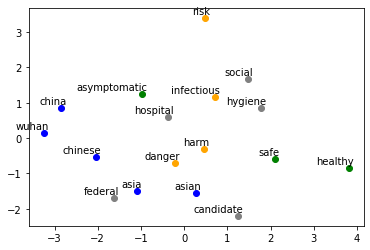

In [ ]:
# Glove real news
words = asia + healthy + danger + all_targets
n = [len(asia), len(asia)+len(healthy), len(asia)+len(healthy)+len(danger), len(asia)+len(healthy)+len(danger)+len(all_targets)]
word_vectors = np.array([real_vec_dict[w] for w in words])
three_dim  = PCA(random_state=0).fit_transform(word_vectors)[:,:3]

plt.scatter(three_dim[:n[0],0], three_dim[:n[0],1], color="blue")
plt.scatter(three_dim[n[0]:n[1],0], three_dim[n[0]:n[1],1], color="green")
plt.scatter(three_dim[n[1]:n[2],0], three_dim[n[1]:n[2],1], color="orange")
plt.scatter(three_dim[n[2]:n[3],0], three_dim[n[2]:n[3],1], color="grey")

for i in range(len(words)):
  plt.annotate(words[i],
                xy=(three_dim[i,0], three_dim[i,1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom'
                )
plt.show()


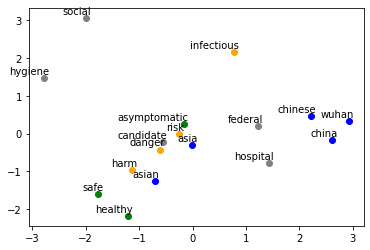

In [ ]:
# Glove fake news

words = asia + healthy + danger + all_targets
n = [len(asia), len(asia)+len(healthy), len(asia)+len(healthy)+len(danger), len(asia)+len(healthy)+len(danger)+len(all_targets)]
word_vectors = np.array([fake_vec_dict[w] for w in words])
three_dim  = PCA(random_state=0).fit_transform(word_vectors)[:,:3]

plt.scatter(three_dim[:n[0],0], three_dim[:n[0],1], color="blue")
plt.scatter(three_dim[n[0]:n[1],0], three_dim[n[0]:n[1],1], color="green")
plt.scatter(three_dim[n[1]:n[2],0], three_dim[n[1]:n[2],1], color="orange")
plt.scatter(three_dim[n[2]:n[3],0], three_dim[n[2]:n[3],1], color="grey")

for i in range(len(words)):
  plt.annotate(words[i],
                xy=(three_dim[i,0], three_dim[i,1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom'
                )
plt.show()


In [ ]:
# Vaccine bias

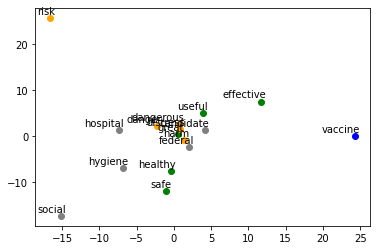

In [ ]:
words = vac + provac + antivac + all_targets
n = [len(vac), len(vac)+len(provac), len(vac)+len(provac)+len(antivac), len(vac)+len(provac)+len(antivac)+len(all_targets)]
word_vectors = np.array([w2v_model_real.wv[w] for w in words])
three_dim  = PCA(random_state=0).fit_transform(word_vectors)[:,:3]

plt.scatter(three_dim[:n[0],0], three_dim[:n[0],1], color="blue")
plt.scatter(three_dim[n[0]:n[1],0], three_dim[n[0]:n[1],1], color="green")
plt.scatter(three_dim[n[1]:n[2],0], three_dim[n[1]:n[2],1], color="orange")
plt.scatter(three_dim[n[2]:n[3],0], three_dim[n[2]:n[3],1], color="grey")

for i in range(len(words)):
  plt.annotate(words[i],
                xy=(three_dim[i,0], three_dim[i,1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom'
                )
plt.show()



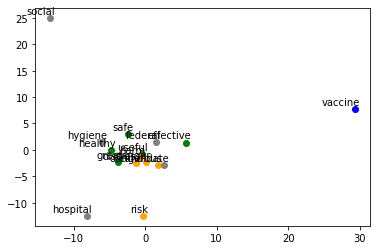

In [ ]:
words = vac + provac + antivac + all_targets
n = [len(vac), len(vac)+len(provac), len(vac)+len(provac)+len(antivac), len(vac)+len(provac)+len(antivac)+len(all_targets)]
word_vectors = np.array([w2v_model_fake.wv[w] for w in words])
three_dim  = PCA(random_state=0).fit_transform(word_vectors)[:,:3]

plt.scatter(three_dim[:n[0],0], three_dim[:n[0],1], color="blue")
plt.scatter(three_dim[n[0]:n[1],0], three_dim[n[0]:n[1],1], color="green")
plt.scatter(three_dim[n[1]:n[2],0], three_dim[n[1]:n[2],1], color="orange")
plt.scatter(three_dim[n[2]:n[3],0], three_dim[n[2]:n[3],1], color="grey")

for i in range(len(words)):
  plt.annotate(words[i],
                xy=(three_dim[i,0], three_dim[i,1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom'
                )
plt.show()

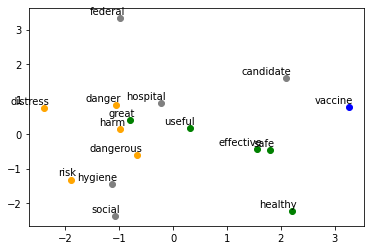

In [ ]:
words = vac + provac + antivac + all_targets
n = [len(vac), len(vac)+len(provac), len(vac)+len(provac)+len(antivac), len(vac)+len(provac)+len(antivac)+len(all_targets)]
word_vectors = np.array([real_vec_dict[w] for w in words])
three_dim  = PCA(random_state=0).fit_transform(word_vectors)[:,:3]

plt.scatter(three_dim[:n[0],0], three_dim[:n[0],1], color="blue")
plt.scatter(three_dim[n[0]:n[1],0], three_dim[n[0]:n[1],1], color="green")
plt.scatter(three_dim[n[1]:n[2],0], three_dim[n[1]:n[2],1], color="orange")
plt.scatter(three_dim[n[2]:n[3],0], three_dim[n[2]:n[3],1], color="grey")

for i in range(len(words)):
  plt.annotate(words[i],
                xy=(three_dim[i,0], three_dim[i,1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom'
                )
plt.show()


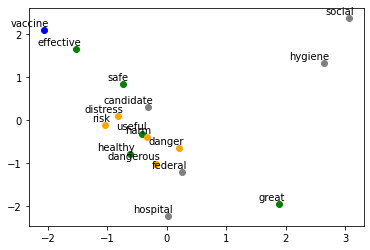

In [ ]:
words = vac + provac + antivac + all_targets
n = [len(vac), len(vac)+len(provac), len(vac)+len(provac)+len(antivac), len(vac)+len(provac)+len(antivac)+len(all_targets)]
word_vectors = np.array([fake_vec_dict[w] for w in words])
three_dim  = PCA(random_state=0).fit_transform(word_vectors)[:,:3]

plt.scatter(three_dim[:n[0],0], three_dim[:n[0],1], color="blue")
plt.scatter(three_dim[n[0]:n[1],0], three_dim[n[0]:n[1],1], color="green")
plt.scatter(three_dim[n[1]:n[2],0], three_dim[n[1]:n[2],1], color="orange")
plt.scatter(three_dim[n[2]:n[3],0], three_dim[n[2]:n[3],1], color="grey")

for i in range(len(words)):
  plt.annotate(words[i],
                xy=(three_dim[i,0], three_dim[i,1]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom'
                )
plt.show()
